In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [6]:
DATA_DIR = '../input/data/'
image_size = 256
batch_size = 32

## Data preprocessing

### Preprocessing Metadata

In [7]:
df = pd.read_csv(f'{DATA_DIR}Data_Entry_2017.csv')

In [8]:
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, 'images*', '*', '*.png'))}
df['path'] = df['Image Index'].map(data_image_paths.get)

In [9]:
df['path'] = df['Image Index'].map(data_image_paths.get)

In [10]:
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

In [43]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030801_001.png
112116,00030802_000.png,,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030802_000.png
112117,00030803_000.png,,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030803_000.png
112118,00030804_000.png,,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030804_000.png


In [9]:
labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x) > 0]

In [34]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [17]:
for label in labels:
    if len(label) > 1:
        df[label] = df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0.0)

In [36]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
labels = [label for label in labels if df[label].sum() > 1000]

In [38]:
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [39]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=2018, stratify=df['Finding Labels'].map(lambda x: x[:4]))

In [40]:
train_df['labels'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
valid_df['labels'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Define DataGenerator

In [41]:
core_idg = ImageDataGenerator(rescale=1 / 255,
                                  samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  height_shift_range=0.05,
                                  width_shift_range=0.1,
                                  rotation_range=5,
                                  shear_range=0.1,
                                  fill_mode='reflect',
                                  zoom_range=0.15)

train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                                       directory=None,
                                                       x_col='path',
                                                       y_col='labels',
                                                       class_mode='categorical',
                                                       batch_size=1024,
                                                       classes=labels,
                                                       target_size=(image_size, image_size)))

Found 41318 validated image filenames belonging to 13 classes.
Found 10331 validated image filenames belonging to 13 classes.
Found 10331 validated image filenames belonging to 13 classes.


## Create model

In [42]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation="sigmoid")(x)
model = tf.keras.Model(base_model.input, output)
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'model.{model_name}.h5',
        verbose=1,
        save_best_only=True)
    # erly = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    callbacks.append(checkpoint)
    # callbacks.append(erly)
    return callbacks

## Train model

In [44]:
callbacks = get_callbacks('inceptionresnetv2')
model.fit(train_gen,
              steps_per_epoch=100,
              validation_data=(test_X, test_Y),
              epochs=50,
              callbacks=callbacks)

Train for 100 steps, validate on 1024 samples
Epoch 1/50
 99/100 [============================>.] - ETA: 2s - loss: 0.3338 - accuracy: 0.8736
Epoch 00001: val_loss improved from inf to 0.59000, saving model to model.inceptionresnetv2.h5
100/100 [==============================] - 225s 2s/step - loss: 0.3339 - accuracy: 0.8737 - val_loss: 0.5900 - val_accuracy: 0.7918
Epoch 2/50
 99/100 [============================>.] - ETA: 1s - loss: 0.3143 - accuracy: 0.8789
Epoch 00002: val_loss improved from 0.59000 to 0.35434, saving model to model.inceptionresnetv2.h5
100/100 [==============================] - 178s 2s/step - loss: 0.3144 - accuracy: 0.8789 - val_loss: 0.3543 - val_accuracy: 0.8533
Epoch 3/50
 99/100 [============================>.] - ETA: 1s - loss: 0.3091 - accuracy: 0.8826
Epoch 00003: val_loss improved from 0.35434 to 0.34793, saving model to model.inceptionresnetv2.h5
100/100 [==============================] - 175s 2s/step - loss: 0.3092 - accuracy: 0.8826 - val_loss: 0.3479 

In [45]:
y_pred = model.predict(test_X)

In [46]:
for label, p_count, t_count in zip(labels,
                                     100 * np.mean(y_pred, 0),
                                     100 * np.mean(test_Y, 0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (label, t_count, p_count))

Atelectasis: actual: 22.36%, predicted: 12.72%
Cardiomegaly: actual: 5.27%, predicted: 3.68%
Consolidation: actual: 8.11%, predicted: 8.11%
Edema: actual: 4.39%, predicted: 3.07%
Effusion: actual: 26.07%, predicted: 29.14%
Emphysema: actual: 4.59%, predicted: 9.00%
Fibrosis: actual: 3.71%, predicted: 2.72%
Infiltration: actual: 36.72%, predicted: 40.43%
Mass: actual: 12.70%, predicted: 12.35%
Nodule: actual: 10.84%, predicted: 11.92%
Pleural_Thickening: actual: 7.13%, predicted: 8.82%
Pneumonia: actual: 3.22%, predicted: 1.85%
Pneumothorax: actual: 9.96%, predicted: 15.74%


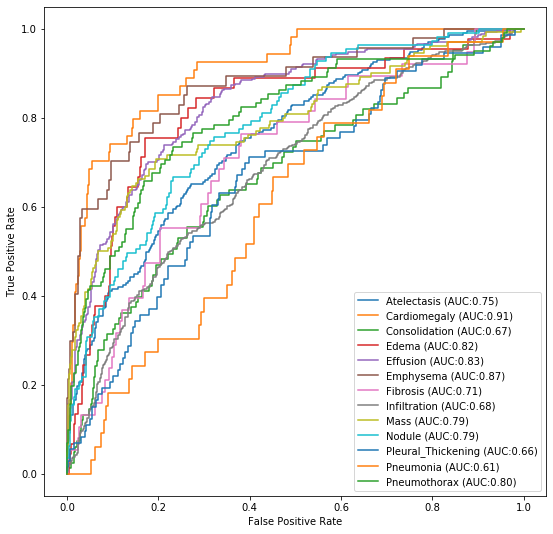

In [47]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [48]:
print('ROC auc score: {:.3f}'.format(roc_auc_score(test_Y.astype(int), y_pred)))

ROC auc score: 0.762


Dimension of Image Features: (256, 256, 1)


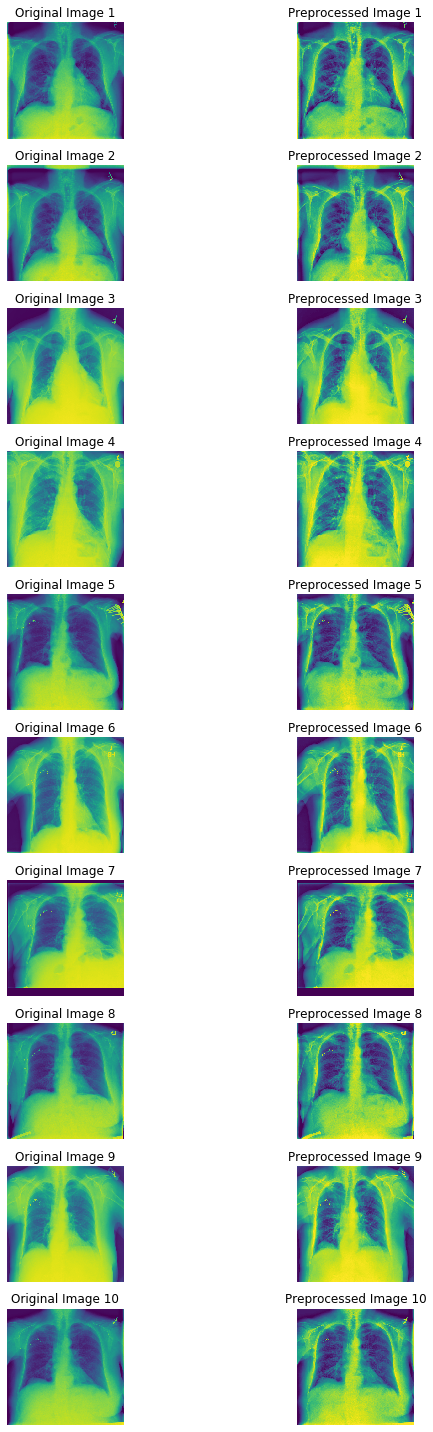

Dimension of Image Features: (256, 256, 1)


In [13]:
import os
import numpy as np
from skimage import exposure, filters
from skimage.color import rgb2gray
from skimage import img_as_ubyte
from PIL import Image
import matplotlib.pyplot as plt

# Create the directory to store preprocessed images
os.makedirs('preprocessed_images', exist_ok=True)

def preprocess_image(image_path, target_size=(256, 256)):
    image = Image.open(image_path)
    image = image.resize(target_size)
    
    # Convert to numpy array and normalize pixel values
    image_array = np.array(image) / 255.0
    
    # Apply CLAHE
    gray_image = rgb2gray(image_array)
    clahe = exposure.equalize_adapthist(gray_image)
    
    # Expand dimensions to add the channel dimension
    expanded_image_array = np.expand_dims(clahe, axis=-1)
    
    # Convert back to 8-bit unsigned integer
    image_array = img_as_ubyte(expanded_image_array)
    
    # Save the preprocessed image to the new directory
    preprocessed_path = os.path.join('preprocessed_images', os.path.basename(image_path))
    preprocessed_image = Image.fromarray(image_array.squeeze())  # Squeeze to remove channel dimension for saving
    preprocessed_image.save(preprocessed_path)
    
    return expanded_image_array


first_10_images = df['path'].head(10)

# Preprocess images and store in 'Image Features' column
df['Image Features'] = first_10_images.apply(preprocess_image)

print(f"Dimension of Image Features: {df['Image Features'].iloc[0].shape}")

first_10_images = df['path'].head(10)

# Preprocess images and store in 'Image Features' column
df['Image Features'] = first_10_images.apply(preprocess_image)

# Display the original and preprocessed images side by side
num_images_to_display = 10

# Create a subplot grid
fig, axes = plt.subplots(num_images_to_display, 2, figsize=(10, 20))

# Iterate over the first few rows in the DataFrame
for i, (_, row) in enumerate(df.head(num_images_to_display).iterrows()):
    original_image = Image.open(row['path'])
    preprocessed_image = Image.open(os.path.join('preprocessed_images', os.path.basename(row['path'])))
       
    ax1, ax2 = axes[i]
    ax1.imshow(original_image)
    ax1.set_title(f"Original Image {i + 1}")
    ax1.axis('off')
       
    ax2.imshow(preprocessed_image)
    ax2.set_title(f"Preprocessed Image {i + 1}")
    ax2.axis('off')

plt.tight_layout()
plt.show()

# Print the dimension of the 'Image Features' column for each image
print(f"Dimension of Image Features: {df['Image Features'].iloc[0].shape}")



In [45]:
first_10_images = df['path'].head(10)

# Preprocess images and store in 'Image Features' column
df['Image Features'] = first_10_images.apply(preprocess_image)

print(f"Dimension of Image Features: {df['Image Features'].iloc[0].shape}")


Dimension of Image Features: (256, 256, 1)


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the bounding box data from CSV
bbox_df = pd.read_csv('../input/data/BBox_List_2017.csv')

# Display the first few rows of the DataFrame
print(len(bbox_df)/len(df))


0.008776311095255084


In [47]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [48]:
model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [49]:
model_weights_path = '/kaggle/input/pretrainedmodels/Unet.hdf5'
model.load_weights(model_weights_path)

In [50]:
import tensorflow as tf
import os
import numpy as np
from skimage import exposure, filters
from skimage.color import rgb2gray
from skimage import img_as_ubyte
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

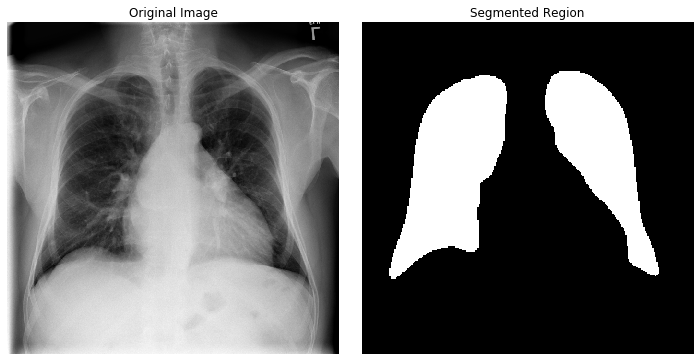

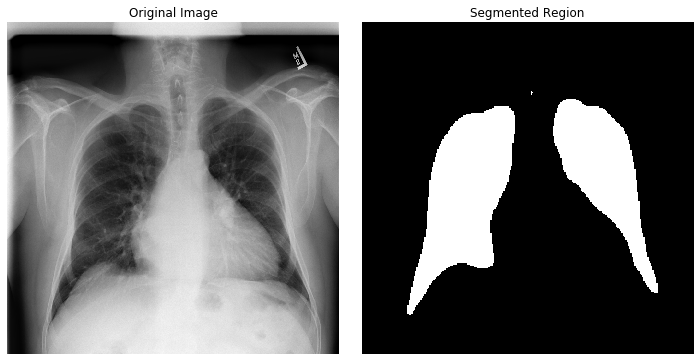

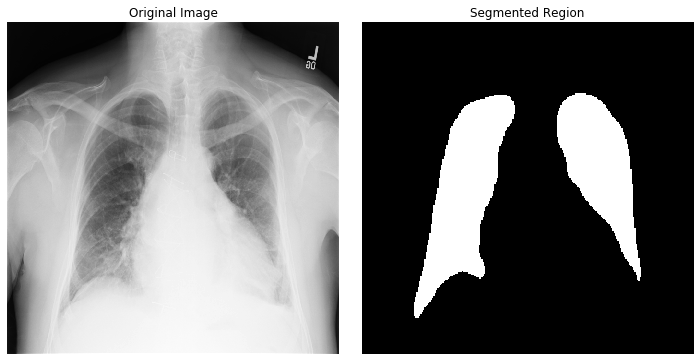

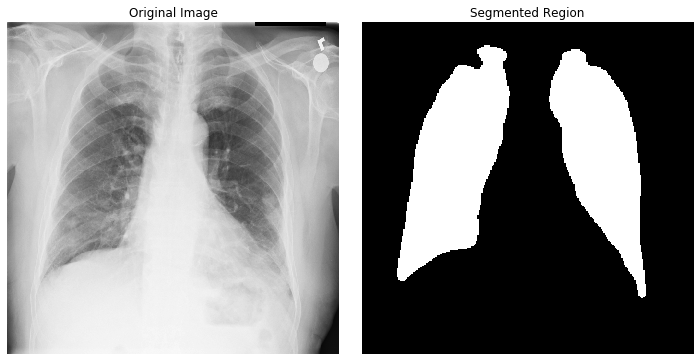

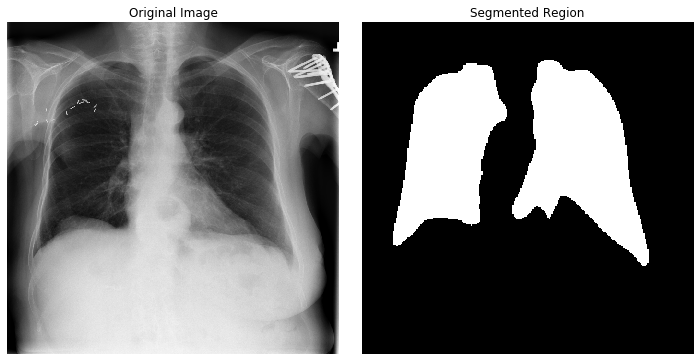

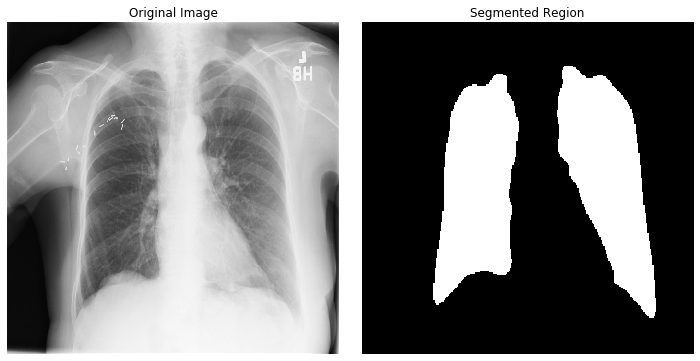

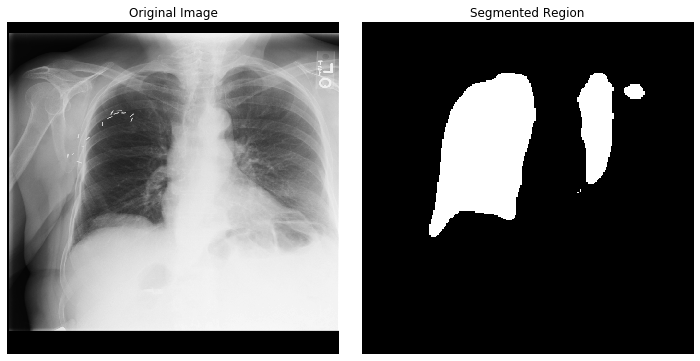

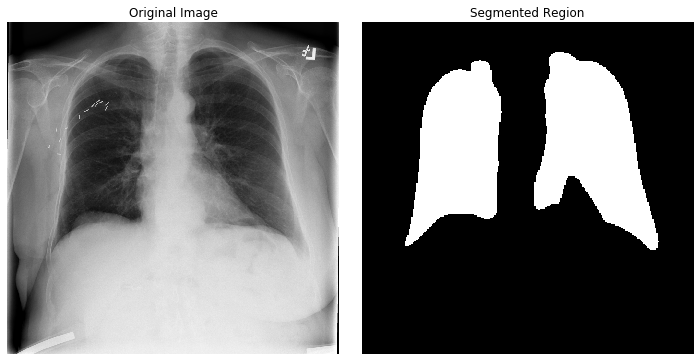

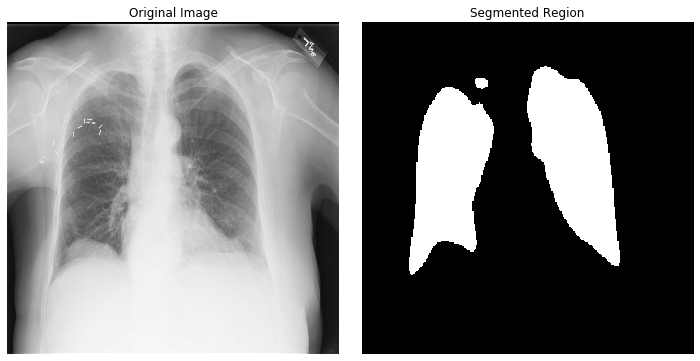

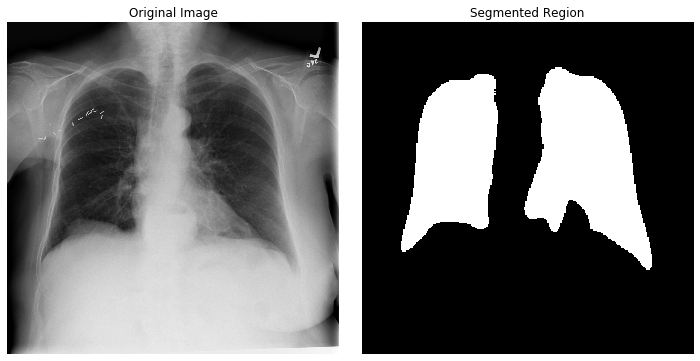

In [65]:
import matplotlib.pyplot as plt

# Threshold value to create binary masks from probability maps
threshold = 0.5

# Initialize an empty list to store binary masks
binary_masks = []

# Iterate through each segmented mask and create binary masks
for segmented_mask in segmented_masks:
    binary_mask = (segmented_mask > threshold).astype(np.uint8)
    binary_masks.append(binary_mask)

# Convert the list of binary masks to a NumPy array
binary_masks = np.array(binary_masks)

# Plot original images and corresponding segmented regions
for i in range(len(binary_masks)):
    original_image = plt.imread(df['path'][i])
    segmented_region = binary_masks[i].squeeze()
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_region, cmap='gray')
    plt.title('Segmented Region')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [76]:
from skimage.measure import regionprops

def extract_shape_features(segmented_region):
    # Define a list to store extracted features
    features = []
    
    # Calculate shape features (e.g., area, perimeter, eccentricity)
    region_properties = regionprops(segmented_region)
    area = region_properties[0].area
    perimeter = region_properties[0].perimeter
    major_axis_length = region_properties[0].major_axis_length
    minor_axis_length = region_properties[0].minor_axis_length
    solidity = region_properties[0].solidity
    extent = region_properties[0].extent
    equivalent_diameter = region_properties[0].equivalent_diameter
    orientation = region_properties[0].orientation
    convex_area = region_properties[0].convex_area
    
    features.extend([area, perimeter, major_axis_length, minor_axis_length, solidity, extent,
                     equivalent_diameter, orientation, convex_area])
    
    return features


In [83]:
extracted_features = []

# Extract age and gender columns from the DataFrame for the first 10 images
age_column = df['Patient Age'].head(10).values
gender_column = df['Patient Gender'].head(10).values

# print(df.head())

# Initialize an empty DataFrame to store the selected columns
selected_columns_df = df.head(10)[['Patient Age', 'Patient Gender','Finding Labels']]

# Iterate through each segmented mask
for i in range(segmented_masks.shape[0]):
    segmented_region = (segmented_masks[i].squeeze() > 0.5).astype(np.uint8)  # Convert to uint8
    
    # Extract shape features from the segmented region
    shape_features = extract_shape_features(segmented_region)
    extracted_features.append(shape_features)

# Convert the list of extracted shape features to a NumPy array
X_shape_features = np.array(extracted_features)

# Create a new DataFrame with the extracted shape features and selected columns
shape_df = pd.DataFrame(X_shape_features, columns=shape_feature_names)
selected_columns_df = pd.concat([selected_columns_df, shape_df], axis=1)

# Print the new DataFrame
print(selected_columns_df)

   Patient Age Patient Gender          Finding Labels     Area   Perimeter  \
0           58              M            Cardiomegaly  14052.0  841.796031   
1           58              M  Cardiomegaly|Emphysema  11882.0  817.689430   
2           58              M   Cardiomegaly|Effusion  10800.0  794.925974   
3           81              M                          16322.0  934.523953   
4           81              F                  Hernia  16099.0  899.565584   
5           74              F                  Hernia  16073.0  915.612265   
6           75              F                  Hernia   8627.0  615.788889   
7           76              F     Hernia|Infiltration  15103.0  868.097546   
8           77              F                  Hernia  12554.0  796.440692   
9           78              F                  Hernia  15417.0  868.239682   

   Major Axis Length  Minor Axis Length  Solidity    Extent  \
0         242.910069         155.829294  0.515235  0.422236   
1         228.8

In [88]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Convert the multi-label 'Finding Labels' into binary columns
disease_labels = selected_columns_df['Finding Labels'].str.get_dummies(sep='|')

# Combine the one-hot encoded gender columns and disease labels
encoded_df = pd.concat([selected_columns_df.drop(['Patient Gender', 'Finding Labels'], axis=1),
                        pd.get_dummies(selected_columns_df['Patient Gender']),
                        disease_labels], axis=1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(encoded_df.drop(disease_labels.columns, axis=1), 
                                                    encoded_df[disease_labels.columns], 
                                                    test_size=0.2, random_state=42)
# Initialize and train the Decision Tree model
disease_tree = DecisionTreeClassifier(random_state=42)
disease_tree.fit(X_train, y_train)

# Predict on the test set
y_pred = disease_tree.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.5


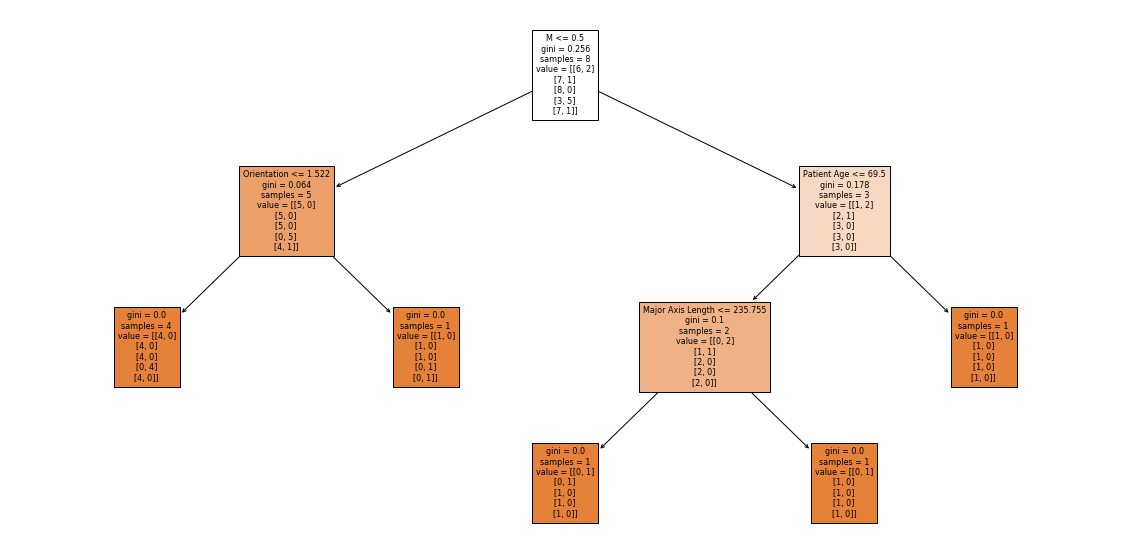

In [89]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(disease_tree, feature_names=X_train.columns, class_names=disease_labels.columns, filled=True, fontsize=8)
plt.show()